In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

In [2]:
import torch
from google.protobuf import text_format
from second.utils import simplevis
from second.pytorch.train import build_network
from second.protos import pipeline_pb2
from second.utils import config_tool

/home/shengchen/Tensorflow/envPy36/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/home/shengchen/Tensorflow/envPy36/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_CUDALIB=/usr/local/cuda-10.1/lib64.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/home/shengchen/Tensorflow/envPy36/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables wit

## Read Config file

In [3]:
def change_detection_range_v2(model_config, new_range):
    assert len(new_range) == 4, "you must provide a list such as [-50, -50, 50, 50]"
    old_pc_range = list(model_config.voxel_generator.point_cloud_range)
    old_pc_range[:2] = new_range[:2]
    old_pc_range[3:5] = new_range[2:]
    model_config.voxel_generator.point_cloud_range[:] = old_pc_range
    for anchor_generator in model_config.target_assigner.class_settings:
        a_type = anchor_generator.WhichOneof('anchor_generator')
        if a_type == "anchor_generator_range":
            a_cfg = anchor_generator.anchor_generator_range
            old_a_range = list(a_cfg.anchor_ranges)
            old_a_range[:2] = new_range[:2]
            old_a_range[3:5] = new_range[2:]
            a_cfg.anchor_ranges[:] = old_a_range
        elif a_type == "anchor_generator_stride":
            a_cfg = anchor_generator.anchor_generator_stride
            old_offset = list(a_cfg.offsets)
            stride = list(a_cfg.strides)
            old_offset[0] = new_range[0] + stride[0] / 2
            old_offset[1] = new_range[1] + stride[1] / 2
            a_cfg.offsets[:] = old_offset
        else:
            raise ValueError("unknown")
    old_post_range = list(model_config.post_center_limit_range)
    old_post_range[:2] = new_range[:2]
    old_post_range[3:5] = new_range[2:]
    model_config.post_center_limit_range[:] = old_post_range

In [4]:
config_path = "/home/shengchen/Kaggle/second.pytorch/second/configs/car.lite.config"
config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
input_cfg = config.eval_input_reader
model_cfg = config.model.second
change_detection_range_v2(model_cfg, [-50, -50, 50, 50])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

## Build Network, Target Assigner and Voxel Generator

In [6]:
ckpt_path = "/home/shengchen/Kaggle/second.pytorch/pretrained_models_v1.5/car_lite/voxelnet-15500.tckpt"
net = build_network(model_cfg).to(device).eval()
net.load_state_dict(torch.load(ckpt_path))
target_assigner = net.target_assigner
voxel_generator = net.voxel_generator

[  41 2000 2000]


## Generate Anchors

In [8]:
grid_size = voxel_generator.grid_size
feature_map_size = grid_size[:2] // config_tool.get_downsample_factor(model_cfg)
feature_map_size = [*feature_map_size, 1][::-1]

anchors = target_assigner.generate_anchors(feature_map_size)["anchors"]
anchors = torch.tensor(anchors, dtype=torch.float32, device=device)
anchors = anchors.view(1, -1, 7)

## Read KITTI infos
you can load your custom point cloud.

In [11]:
info_path = input_cfg.dataset.kitti_info_path
root_path = Path(input_cfg.dataset.kitti_root_path)
with open(info_path, 'rb') as f:
    infos = pickle.load(f)

## Load Point Cloud, Generate Voxels

In [21]:
voxel_generator

In [30]:
info = infos[564]
v_path = info["point_cloud"]['velodyne_path']
v_path = str(root_path / v_path)
points = np.fromfile(
    v_path, dtype=np.float32, count=-1).reshape([-1, 4])
res = voxel_generator.generate(points, max_voxels=90000)
voxels = res['voxels']
coords = res['coordinates']
num_points = res['num_points_per_voxel']
# voxels, coords, num_points, _ = voxel_generator.generate(points, max_voxels=90000)
print(voxels.shape)
# add batch idx to coords
coords = np.pad(coords, ((0, 0), (1, 0)), mode='constant', constant_values=0)
voxels = torch.tensor(voxels, dtype=torch.float32, device=device)
coords = torch.tensor(coords, dtype=torch.int32, device=device)
num_points = torch.tensor(num_points, dtype=torch.int32, device=device)

(84129, 1, 4)


## Detection

In [31]:
example = {
    "anchors": anchors,
    "voxels": voxels,
    "num_points": num_points,
    "coordinates": coords,
}
pred = net(example)[0]

## Simple Vis

In [32]:
boxes_lidar = pred["box3d_lidar"].detach().cpu().numpy()
vis_voxel_size = [0.1, 0.1, 0.1]
vis_point_range = [-50, -30, -3, 50, 30, 1]
bev_map = simplevis.point_to_vis_bev(points, vis_voxel_size, vis_point_range)
bev_map = simplevis.draw_box_in_bev(bev_map, vis_point_range, boxes_lidar, [0, 255, 0], 2)

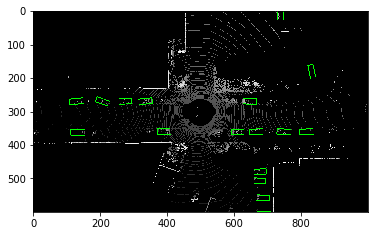

In [33]:
plt.imshow(bev_map)